## Importing libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
import random

## Setting seed

In [3]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [4]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [5]:
X_train, y_train = load_dataset('../ShanghaiTech/part_B/train_data/images/', '../ShanghaiTech/part_B/train_data/ground-truth/')

In [6]:
X_test, y_test = load_dataset('../ShanghaiTech/part_B/test_data/images/', '../ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [7]:
# Load pre-trained model without top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# base_model.trainable = True
# for layer in base_model.layers[:-3]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [8]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - loss: 21816.6426 - mae: 113.1244 - val_loss: 12112.9785 - val_mae: 72.7853
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 11675.7021 - mae: 77.9591 - val_loss: 9564.3496 - val_mae: 73.1700
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 9263.9717 - mae: 74.7744 - val_loss: 9203.5605 - val_mae: 70.6013
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 9239.6582 - mae: 73.0384 - val_loss: 9040.9688 - val_mae: 66.8197
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 8841.8105 - mae: 68.5641 - val_loss: 8713.1816 - val_mae: 64.8126
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 8584.4404 - mae: 68.7577 - val_loss: 8328.6270 - val_mae: 63.2922
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 7915.2881 - mae: 64.7969 - val_loss: 8124.7539 - val_mae: 61.1038
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 8381.1133 - mae: 65.1958 - val_loss: 7836.2310 - val_mae: 59.4836
Epoc

## Training curves visualisation

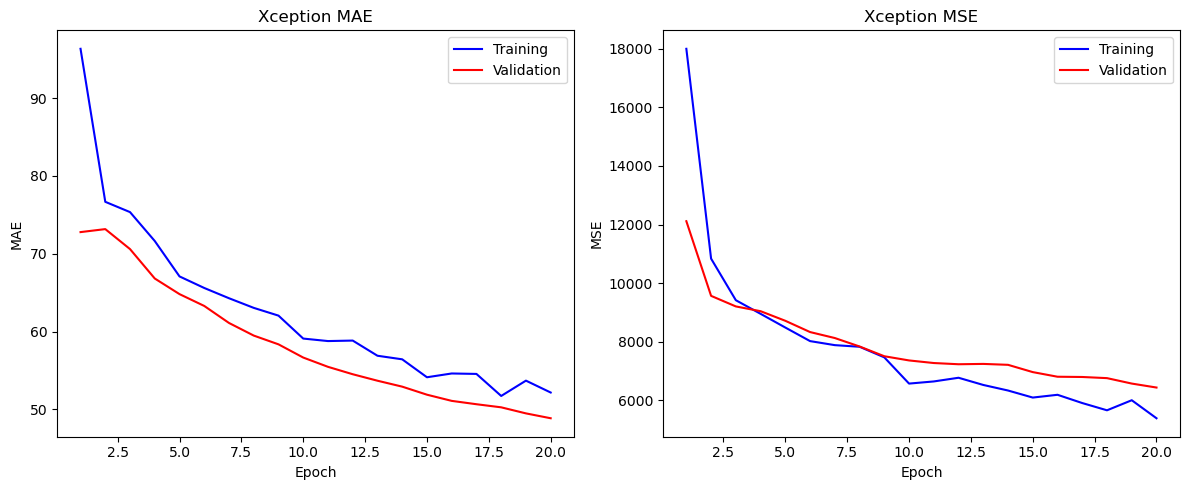

In [9]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Xception MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Xception MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [10]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step


In [11]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 38.  23.]
 [106. 181.]
 [143. 157.]
 [ 43.  37.]
 [150.  70.]
 [114.  57.]
 [ 32.  44.]
 [157. 227.]
 [121. 165.]
 [140. 476.]
 [101. 139.]
 [144. 316.]
 [133. 164.]
 [ 92. 110.]
 [ 52.  20.]
 [108. 131.]
 [ 54.  48.]
 [149. 183.]
 [ 96. 101.]
 [176. 204.]
 [ 74.  40.]
 [ 91. 143.]
 [ 97. 146.]
 [137. 513.]
 [ 64.  70.]
 [ 91. 175.]
 [ 61.  51.]
 [ 93.  55.]
 [102.  67.]
 [107.  72.]
 [ 51.  56.]
 [124. 165.]
 [ 22.  32.]
 [ 97. 149.]
 [ 86.  48.]
 [ 68.  80.]
 [103. 117.]
 [ 60. 162.]
 [116. 137.]
 [134. 120.]
 [117.  72.]
 [130. 122.]
 [103. 198.]
 [ 75. 133.]
 [ 84. 147.]
 [ 60.  29.]
 [ 27.  70.]
 [ 53.  35.]
 [ 29.  24.]
 [134. 251.]
 [100.  59.]
 [101.  67.]
 [ 64.  61.]
 [134. 248.]
 [175. 252.]
 [134. 147.]
 [ 43.  57.]
 [101. 121.]
 [ 21.  47.]
 [207. 505.]
 [155. 297.]
 [166. 465.]
 [128. 167.]
 [ 75.  43.]
 [ 41.  46.]
 [ 97.  91.]
 [131. 263.]
 [ 76.  92.]
 [129. 117.]
 [ 51.  48.]
 [ 95.  54.]
 [ 85.  73.]
 [131. 122.]
 [116.  60.]
 [153. 170.]
 [ 54. 167.]
 [ 38.  57.]

## Metrics

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.2888432741165161
MSE: 6436.07275390625
MAE: 48.84493637084961
RMSE: 80.22513580322266
